## Time Series Analysis of Champagne Sales

**The Perrin-Freres champagne is a popular French champagne that does well in the market. The dataset consists of monthly sales records for the nine years between 1964 and 1972.**

**See if you can build the best ARIMA model that can capture the sales data well with accurate predictions, with the lowest AR and MA orders possible for a parsimonious model.**

**You should use all the tools available; Adfuller test, auto ARIMA, ACF & PACF plots etc.**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

%matplotlib inline

In [3]:
import pmdarima as pm

In [5]:
df = pd.read_csv('data/perrin-freres-monthly-champagne.csv', index_col='Month', skipfooter=2, parse_dates=True, engine='python')

In [6]:
df.head()

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [7]:
# Change col name

df.columns = ['Sales']

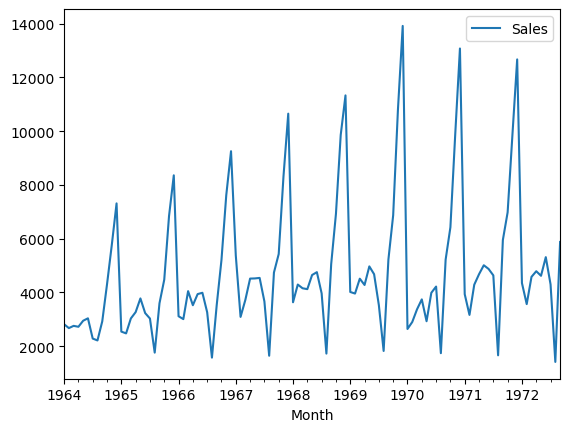

In [8]:
df.plot();

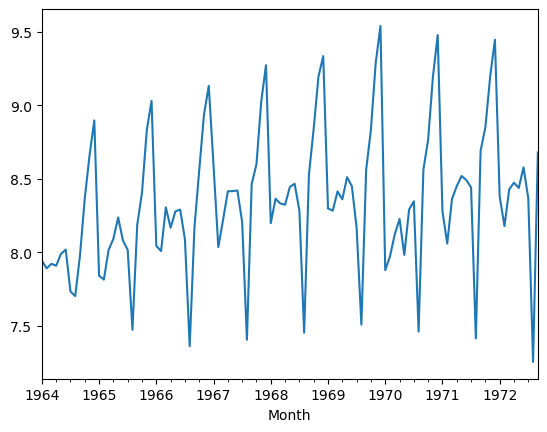

In [9]:
# Calculate log sales and plot

df['LogSales'] = np.log(df['Sales'])

df['LogSales'].plot();

**The log-transformed plot shows a more constant mean and variance throughout, with evidence of seasonality. You can account for seasonality in the auto ARIMA model (SARIMAX) or keep the model purely non-seasonal ARIMA with higher `p` and `q` orders.**

In [10]:
# Set index frequency

df.index.freq = 'MS'

In [11]:
# Create training and test sets

N_test = 12

train = df.iloc[: -N_test]
test = df.iloc[-N_test :]

In [12]:
# Boolean series to index df rows and help with plotting full data against predictions

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

## Build seasonal auto ARIMA model with default settings

**Use the log-transformed data to ensure greater stationarity.**

In [13]:
model = pm.auto_arima(train['LogSales'],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=True, 
                      m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-50.522, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-41.975, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-54.968, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-53.384, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-34.700, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-44.102, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-52.971, Time=0.47 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-52.991, Time=0.28 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-55.117, Time=0.13 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=-53.123, Time=0.39 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-50.817, Time=0.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=-56.123, Time=0.23 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=-44.178, Time=0.07 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   93
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  33.917
Date:                            Wed, 06 Sep 2023   AIC                            -57.834
Time:                                    11:37:21   BIC                            -45.862
Sample:                                01-01-1964   HQIC                           -53.031
                                     - 09-01-1971                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0083      0.011      0.774      0.439      -0.013       0.029
ar.L1          0.8619      0.160      5.383      0.000       0.548       1.176
ma.L1         -0.6695      0.220     -3.044      0.002      -1.101      -0.238
ma.S.L12      -0.4795      0.116     -4.119      0.000      -0.708      -0.251
sigma2         0.0244      0.003      8.575      0.000       0.019       0.030
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                24.76
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                            -0.68
Prob(H) (two-sided):                  0.51   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Using the log-transformed data, auto ARIMA has deemed that the best SARIMAX model parmaters are `order=(1, 0, 1)` and `seasonal_order=(0, 1, 1, 12)`.**

**For the non-seasonal part, AR(1) and MA(1) with one differencing is best suited for time series.**

**For the seasonal part, it is pure MA(1) model and seasonal differencing with a period of 12 months.**

**Since the model is seasonal, you should not predict and plot the first twelve values in the time series, so for in-sample predictions, make sure to start from index 12.**

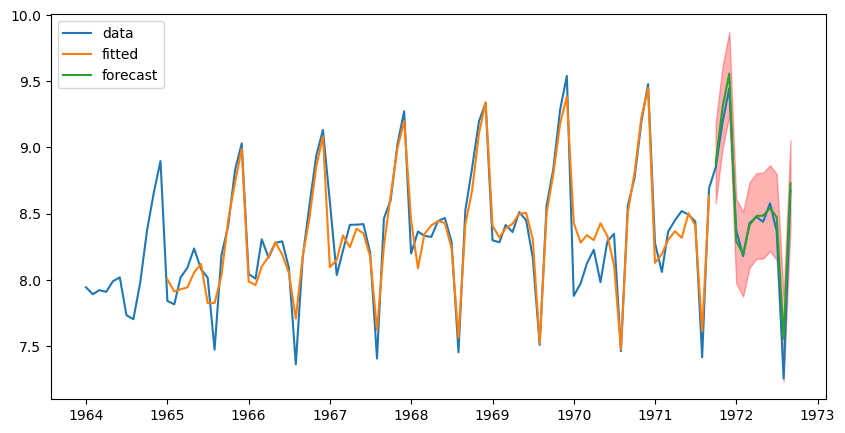

In [15]:
train_pred = model.predict_in_sample(start=12, end=-1)
test_pred, confint = model.predict(n_periods=N_test, return_conf_int=True)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df.index, df['LogSales'], label='data')
ax.plot(train.index[12:], train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)
ax.legend();

### Compute R-Squared metric

In [16]:
r2_score(test['Sales'], np.exp(test_pred))

0.9546886034257128

**This model is pretty good even with default settings, as the forecasts closely match the true data. A high R2 score means approx. 95% of variation is accounted for by the SARIMAX model `order=(1, 0, 1) seasonal_order=(0, 1, 1, 12)`.**

## Build non-seasonal auto ARIMA model

**See if you can build a good non-seasonal model by increasing the order values in parameter settings. Remember that the `max_p` and `max_q` are set quite low by default, so you can increase the limits and test model performance, at the cost of computation time. If you increase the maximum order parameters then you must also edit the `max_order` value, which is also set quite low by default.**

**If you build a model with the seasonal part silenced, you can demonstrate how much of the pattern of the data can be captured purely by non-seasonal AR and MA components.**

**Since you are searching for the best combination possible and the dataset is not so large, you can try a full grid search instead of stepwise to ensure that every possible combination is tested.**

In [17]:
model = pm.auto_arima(train['LogSales'],
                      trace=True,
                      max_p=12, 
                      max_q=2, 
                      max_order=14,
                      suppress_warnings=True,
                      stepwise=False,
                      seasonal=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=141.911, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=141.540, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=139.851, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=138.023, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=114.336, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=114.576, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=114.173, Time=0.08 

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   93
Model:              SARIMAX(12, 1, 1)   Log Likelihood                  24.904
Date:                Wed, 06 Sep 2023   AIC                            -19.808
Time:                        12:09:36   BIC                             18.019
Sample:                    01-01-1964   HQIC                            -4.541
                         - 09-01-1971                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0091      0.015      0.603      0.547      -0.021       0.039
ar.L1         -0.0722      0.268     -0.269      0.788      -0.598       0.454
ar.L2         -0.1526      0.201     -0.759      0.448      -0.547       0.242
ar.L3         -0.0975      0.237     -0.411      0.681      -0.562       0.367
ar.L4         -0.2048      0.210     -0.975      0.330      -0.616       0.207
ar.L5         -0.1252      0.240     -0.522      0.602      -0.595       0.345
ar.L6         -0.1235      0.224     -0.551      0.582      -0.563       0.316
ar.L7         -0.0732      0.231     -0.317      0.751      -0.525       0.379
ar.L8         -0.2310      0.214     -1.078      0.281      -0.651       0.189
ar.L9         -0.1073      0.226     -0.475      0.635      -0.550       0.335
ar.L10        -0.1144      0.226     -0.505      0.613      -0.558       0.329
ar.L11        -0.0768      0.218     -0.352      0.725      -0.505       0.351
ar.L12         0.7142      0.191      3.741      0.000       0.340       1.088
ma.L1         -0.6962      0.301     -2.310      0.021      -1.287      -0.105
sigma2         0.0275      0.004      7.428      0.000       0.020       0.035
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                16.73
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.65
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**This model is quite different, with much higher AR order of `p` showing that the past twelve values are important, `(12, 1, 1)`, i.e. no seasonal part. The seasonality seems to be captured mostly by the AR(12) component, rather than the MA(1) component. The differencing makes sense to ensure stationarity in the time series.**

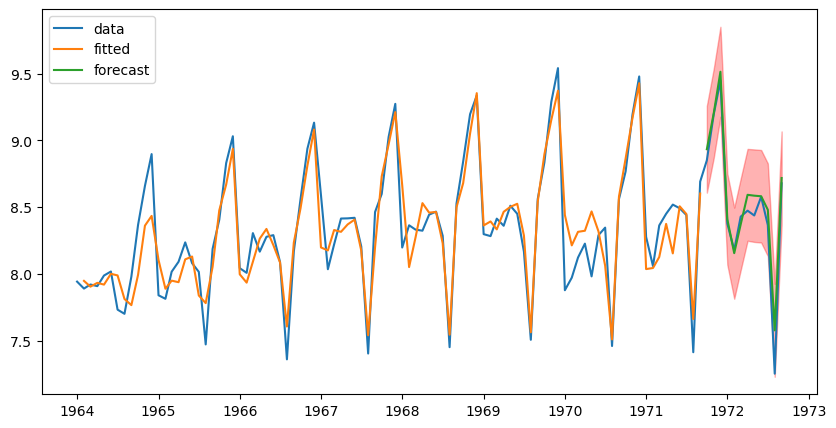

In [19]:
# Remember to start in-sample predictions from 1 due to differencing

train_pred = model.predict_in_sample(start=1, end=-1)
test_pred, confint = model.predict(n_periods=N_test, return_conf_int=True)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df.index, df['LogSales'], label='data')
ax.plot(train.index[1:], train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)
ax.legend();

In [20]:
r2_score(test['Sales'], np.exp(test_pred))

0.9717352238068865

**Better! With `ARIMA(12, 1, 1)`, the predictions follow the actual data better and accuracy has improved by approx. 2%.**

### ACF and PACF plots

**Use ACF and PACF plots to determine if there are better order values for the AR and MA components in ARIMA.**

In [21]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

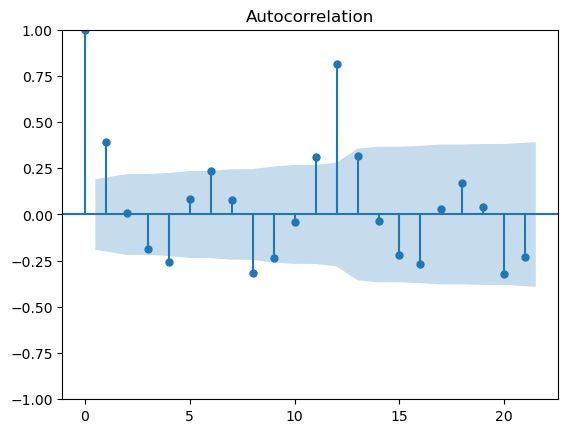

In [22]:
plot_acf(df['LogSales']);

**According the ACF plot, the best order `q` of MA component is 12, opposite to auto ARIMA.**

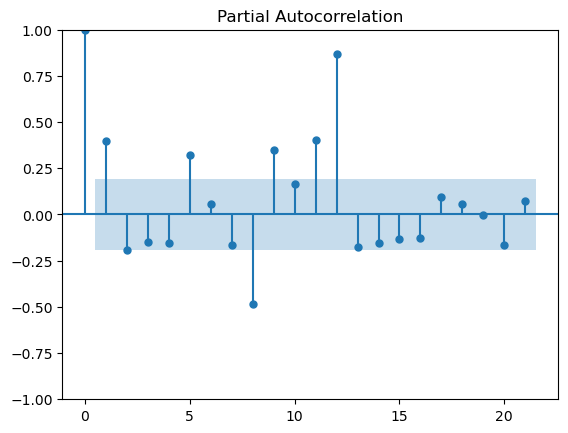

In [23]:
# Without OLS method, you get a weird error message

plot_pacf(df['LogSales'], method='ols');

**According to the PACF plot, the best order `p` of AR component is also 12, same as the auto ARIMA model, hence `ARIMA(12, 0, 12)`.**

**Lets see if differencing the logged data will lower the orders for AR and MA components.**

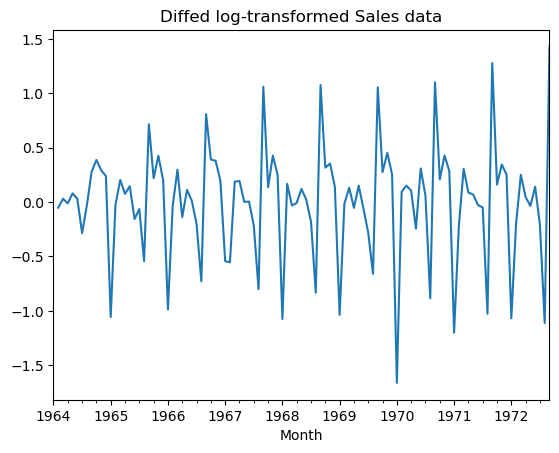

In [24]:
df['LogSales'].diff().plot()
plt.title("Diffed log-transformed Sales data");

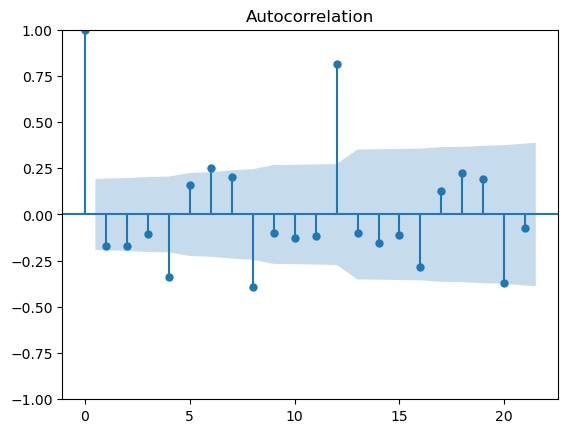

In [25]:
# Plot autocorrelation for differenced log data

plot_acf(df['LogSales'].diff().dropna());

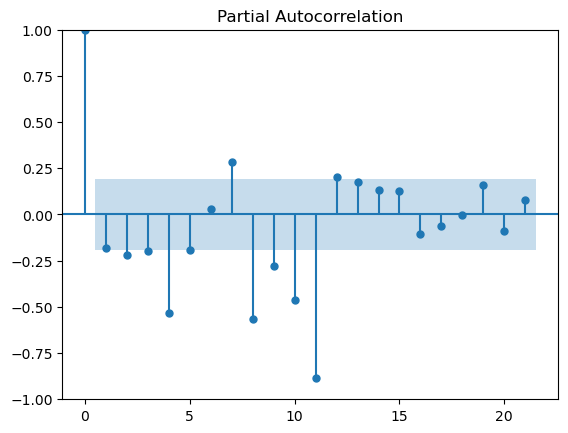

In [26]:
plot_pacf(df['LogSales'].diff().dropna(), method='ols');

**According to the PACF plot, the best order of `p` is AR(11), and according to the ACF plot, the best order of `q` is MA(12). This means that the best ARIMA model contains `AR(11)` and `MA(12)` components, hence `ARIMA(11, 0, 12)`.**

### Test for stationarity

**Before building a new ARIMA model with StatsModel, you can formally test for stationarity in the log-transformed data and the diffed log-transformed data using `adfuller()` function. You need to check and justify what order of differencing to use in the ARIMA model.**

In [27]:
from statsmodels.tsa.stattools import adfuller

In [28]:
adfuller(df['LogSales'])

(-2.2551186012844378,
 0.18685173111686953,
 13,
 91,
 {'1%': -3.50434289821397,
  '5%': -2.8938659630479413,
  '10%': -2.5840147047458037},
 -49.1914375158301)

In [29]:
# Greater than 0.05 - not stationary

print("P-value:", adfuller(df['LogSales'])[1])

P-value: 0.18685173111686953


In [31]:
# Less than 0.05 - STATIONARY!!

print("P-value:", adfuller(df['LogSales'].diff().dropna())[1])

P-value: 0.00023121404649534838


**Using the ACF and PACF values, with confirmation that the log-transformed data needs differencing once to be made stationary, it is estimated that `ARIMA(11, 1, 12)` is the best combination for capturing the champagne sales data.**

### Evaluate ACF and PACF values with StatsModel `ARIMA`

In [32]:
# Function to train, forecast and plot the full data - accepts fitted model, differencing order & time series

def plot_fit_and_forecast(result, d=0, col='Sales'):
    fig, ax = plt.subplots(figsize=(10, 5)) 
    ax.plot(df[col], label='data') 
    
    # Plot the curve fitted on train set 
    train_pred = result.fittedvalues 
    ax.plot(train.index[d:], train_pred[d:], color='green', label='fitted') 
    
    # Forecast the test set 
    prediction_result = result.get_forecast(N_test) 
    conf_int = prediction_result.conf_int() 
    lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}'] 
    forecast = prediction_result.predicted_mean 
    ax.plot(test.index, forecast, label='forecast') 
    ax.fill_between(test.index, lower, upper, color='red', alpha=0.3) 
    ax.legend() 
    
    return forecast

In [37]:
# Nasty user warning due to settings in ARIMA to handle seasonality-type patterns

arima = ARIMA(train['LogSales'], order=(11, 1, 12))

arima_result = arima.fit()

C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


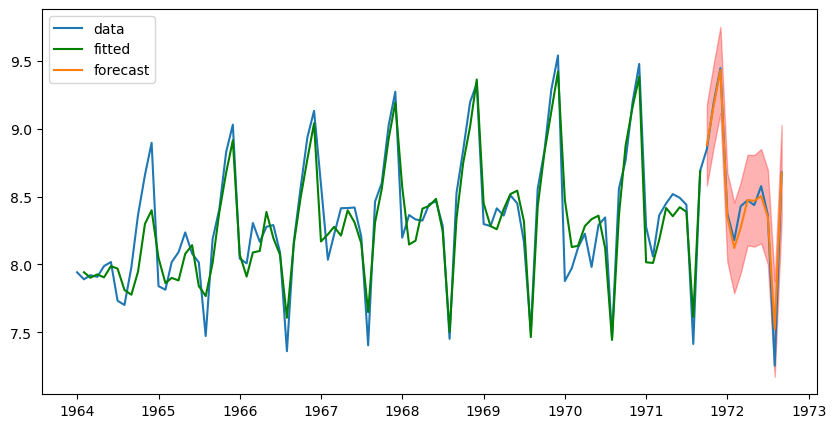

In [38]:
forecast = plot_fit_and_forecast(arima_result, d=1, col='LogSales')

### Assess ARIMA model with R-Squared metric

In [39]:
r2_score(test['Sales'], np.exp(forecast))

0.9899824182116834

**The forecast data fits the true data best with the highest R2 score so far. However, due to that nasty user warning it may be better to use SARIMAX with seasonality defined to have a more robust model. Even though you can use this model to make forecasts, you cannot know for sure based on just ARIMA modelling. Use Walk-Forward Validation steps and deomposition to ascertain the best analysis output.**